# Tiny MNIST Challenge
Author: Agnieszka Mikołajczyk

Gdańsk University of Technology

Methods of Artificial Intelligence

Challenge: https://www.kaggle.com/c/msi-tinymnist2020/overview
Colab: https://colab.research.google.com/drive/11MZBLRatBPMW6PeqZMhVhwg-I43QZcFL

# Hand-written digits recognition 2020

![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/2/27/MnistExamples.png/220px-MnistExamples.png)

### Introduction

As a first step you have to get your kaggle *token*. Log into your kaggle account and go to *My Account* section. Click *Create new API token* and download it. Open you *kaggle.json*. You should see something like this:

 {`“username”:”YOUR-USERNAME”,”key”:”YOUR-VERY-LONG-KEY”}`

Copy that and insert in the code below.

In [0]:
import os
os.environ['KAGGLE_USERNAME'] = "xxxxxxxxx" # username from the json file
os.environ['KAGGLE_KEY'] = "xxxxxxxxxxxxxxxxxxxxxxxxxxxxx" # key from the json file

Now we will install necessary libraries.

*  kaggle API - useful for sending submissions  https://github.com/Kaggle/kaggle-api
*   torch and torchvision - pytorch library, perfect for training neural networks https://pytorch.org/



In [0]:
!pip install --upgrade kaggle
!pip install torch
!pip install torchvision

Now, go to your kaggle account and download dataset. Upload it below.

In [0]:
from google.colab import files
uploaded = files.upload()

In [0]:
!unzip -q TinyMNIST.zip #uzipping dataset

Now we will seed everything so the results are reproducible

In [0]:
import random
import numpy as np
import torch
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(2020)

## Loading data
Now, we will preprocess and load training set

In [0]:
NUM_EPOCHS = 20 # number of times which the entire dataset is passed throughout the model
BATCH_SIZE = 64 # the size of input data took for one iteration
lr = 1e-3 # size of step

In [5]:
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable

train_dataset = dsets.ImageFolder(
        root='TinyMNIST/train',
        transform=transforms.Compose([transforms.Grayscale(num_output_channels=1),transforms.ToTensor()])
    )

train_set,valid_set =torch.utils.data.random_split(train_dataset, [3200, 800])

train_gen = torch.utils.data.DataLoader(dataset=train_set,
                                             batch_size = BATCH_SIZE,
                                             shuffle = True)

valid_gen = torch.utils.data.DataLoader(dataset = valid_set,
                                      batch_size = 800, 
                                      shuffle = False)


print('Loaded ', len(train_set), 'training images and ', len(valid_set), ' validation images.')
print('Classes detected: ', train_dataset.classes)

Loaded  3200 training images and  800  validation images.
Classes detected:  ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


## Architecture
Defining simple net - fully connected network with 2 layers.

In [0]:
class ConvNetwork(nn.Module):
  def __init__(self):
    super(ConvNetwork,self).__init__()
    # definition of layers
    self.conv1 = nn.Conv2d(1, 16, kernel_size=5) # convolutional layer
    self.relu = nn.ReLU() # activation function: relu
    self.conv2 = nn.Conv2d(16, 32, kernel_size=5) # second convolutional layer
    self.fc = nn.Linear(32*20*20, 10) # output layer

  # definition how the signal goes through the network
  def forward(self,x):
    x = self.conv1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = x.view(-1, 32*20*20)
    out = self.fc(x)
    return out

In [0]:
net = ConvNetwork()


## Define loss function

In [0]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

## Training

In [9]:
print('Start training') 
for epoch in range(NUM_EPOCHS):
  
  for i,(images,labels) in enumerate(train_gen):

    optimizer.zero_grad()
    outputs = net(images)

    loss = loss_function(outputs, labels)
    loss.backward()
    optimizer.step()
  
  print('\repoch: ',epoch,"/ ",NUM_EPOCHS, loss,end="")  

Start training
epoch:  19 /  20 tensor(0.0005, grad_fn=<NllLossBackward>)

## Testing neural network

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


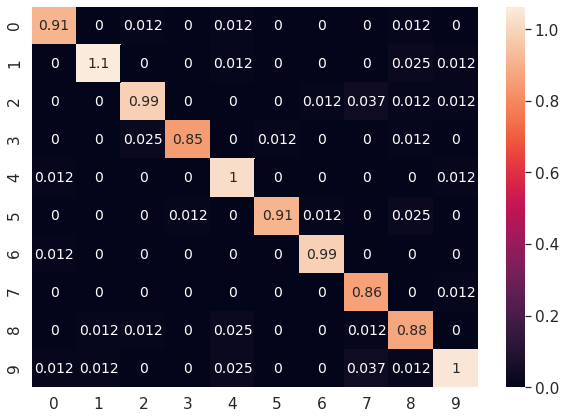

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(valid_gen):
  confusion_matrix = torch.zeros(10, 10)
  with torch.no_grad():
      for i, (images,labels) in enumerate(valid_gen):
          outputs = net(images)
          _, preds = torch.max(outputs, 1)
         
          for t, p in zip(labels.view(-1), preds.view(-1)):
                  confusion_matrix[t.long(), p.long()] += 1

  df_cm = pd.DataFrame(confusion_matrix.cpu().detach().numpy()/len(valid_gen.dataset)*10, range(10), range(10))
  plt.figure(figsize=(10,7))
  sn.set(font_scale=1.4) # for label size
  sn.heatmap(df_cm, annot=True, annot_kws={"size": 14}) # font size
  plt.show()

plot_confusion_matrix(valid_gen)

# Let's generate outputs for test data!

In [11]:
def predict(test_gen):
  with torch.no_grad():
  
      for data, labels in test_gen:
        print(data.size())
        outputs = net(data)
        _, preds = torch.max(outputs, 1)
  return preds

test_dataset = dsets.ImageFolder(
        root='TinyMNIST/test',
        transform=transforms.Compose([transforms.Grayscale(num_output_channels=1),transforms.ToTensor()]),
    )

test_gen = torch.utils.data.DataLoader(dataset=test_dataset,
                                             batch_size = 600,
                                             shuffle = False)
preds = predict(test_gen)


torch.Size([600, 1, 28, 28])


# Generate submission file
Now, finally we can generate submission file with our test data. We will define a new function because we might want to use it later.

In [12]:
def generate_submission(predictions,test_dataset):
  ids = []
  labels = []
  for predictions,sample in zip(predictions,test_dataset.imgs):
    ids.append(predictions)
    sample=list(sample)[0]
    labels.append(int(sample.split("_",1)[1].split(".",1)[0]))
  ids_s,labels_s = zip(*sorted(zip(labels, ids)))
  df = pd.DataFrame()
  df['id']=ids_s
  df['category']=labels_s
  df.set_index('id',inplace = True)
  print(df.head())
  df.to_csv('test_submission.csv', header=True)

generate_submission(preds,test_dataset)

    category
id          
0          1
1          0
2          1
3          4
4          0


# Send submission using kaggle API

In [0]:
!kaggle competitions submit -c msi-tinymnist2020 -f test_submission.csv -m "Jupyter notebook test submission"

100% 3.42k/3.42k [00:04<00:00, 870B/s]
Successfully submitted to MSI Tiny MNIST Challenge 2020